# Consistency between the dataset underpinning the Copernicus Interactive Climate Atlas and its origins: Multiple origin datasets

**Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch.**

Production date: DD-MM-YYYY

Dataset version: 2.0.

Produced by: C3S2_521 contract.

## 🌍 Use case: Retrieving climate indicators from the Copernicus Interactive Climate Atlas

## ❓ Quality assessment question
* **Are the climate indicators in the dataset underpinning the Copernicus Interactive Climate Atlas consistent with their origin datasets?**
* **Can the dataset underpinning the Copernicus Interactive Climate Atlas be reproduced from its origin datasets?**

The [_Copernicus Interactive Climate Atlas_](https://atlas.climate.copernicus.eu/atlas), or _Atlas_ for short, is a C3S web application providing an easy-to-access tool for exploring climate projections, reanalyses, and observational data [[Guti24](https://doi.org/10.21957/ah52ufc369)].
Version 2.0 of the application allows the user to interact with 12 datasets:

| Type               | Dataset       |
|--------------------|---------------|
| Climate Projection | CMIP6         |
| Climate Projection | CMIP5         |
| Climate Projection | CORDEX-CORE   |
| Climate Projection | CORDEX-EUR-11 |
| Reanalysis         | ERA5          |
| Reanalysis         | ERA5-Land     |
| Reanalysis         | ORAS5         |
| Reanalysis         | CERRA         |
| Observations       | E-OBS         |
| Observations       | BERKEARTH     |
| Observations       | CPC           |
| Observations       | SST-CCI       |

These datasets are provided through an intermediary dataset, the [_Gridded dataset underpinning the Copernicus Interactive Climate Atlas_](https://doi.org/10.24381/cds.h35hb680) or _Atlas dataset_ for short [[AtlasData](https://doi.org/10.24381/cds.h35hb680)].
Compared to their origins, the versions of the climate datasets within the Atlas dataset have been processed following the workflow in Figure {numref}`{number} <multi-origin-c3s-atlas_consistency_q03_workflow-fig>`.

```{figure} attachment:atlas_dataset_workflow.png
---
height: 360px
name: multi-origin-c3s-atlas_consistency_q03_workflow-fig
---
Schematic representation of the workflow for the production of the Atlas dataset from its origin datasets, from the [User-tools for the C3S Atlas](https://ecmwf-projects.github.io/c3s-atlas/chapter01.html).
```

Because a wide range of users interact with climate data through the Atlas application, it is crucial that the underpinning dataset represent its origins correctly.
In other words, the Atlas dataset must be consistent with and reproducible from its origins.
Here, we assess this consistency and reproducibility by comparing climate indicators retrieved from the Atlas dataset with their equivalents calculated from the origin dataset, mirroring the workflow from Figure {numref}`{number} <multi-origin-c3s-atlas_consistency_q03_workflow-fig>`.
While a full analysis and reproduction of every record within the Atlas dataset is outside the scope of quality assessment
(and would require high-performance computing infrastructure),
a case study with a narrower scope probes these quality attributes of the dataset
and can be a jumping-off point for further analysis by the reader.

This notebook is part of a series:
| Notebook | Contents |
|---|---|
| [](./derived_multi-origin-c3s-atlas_consistency_q01) | Comparison between Atlas dataset and one origin dataset (CMIP6) for one indicator (`tx35`), including detailed setup. |
| [](./derived_multi-origin-c3s-atlas_consistency_q02) | Comparison between Atlas dataset and one origin dataset (CMIP6) for multiple indicators. |
| [](./derived_multi-origin-c3s-atlas_consistency_q03) | Comparison between Atlas dataset and multiple origin datasets for one indicator. |
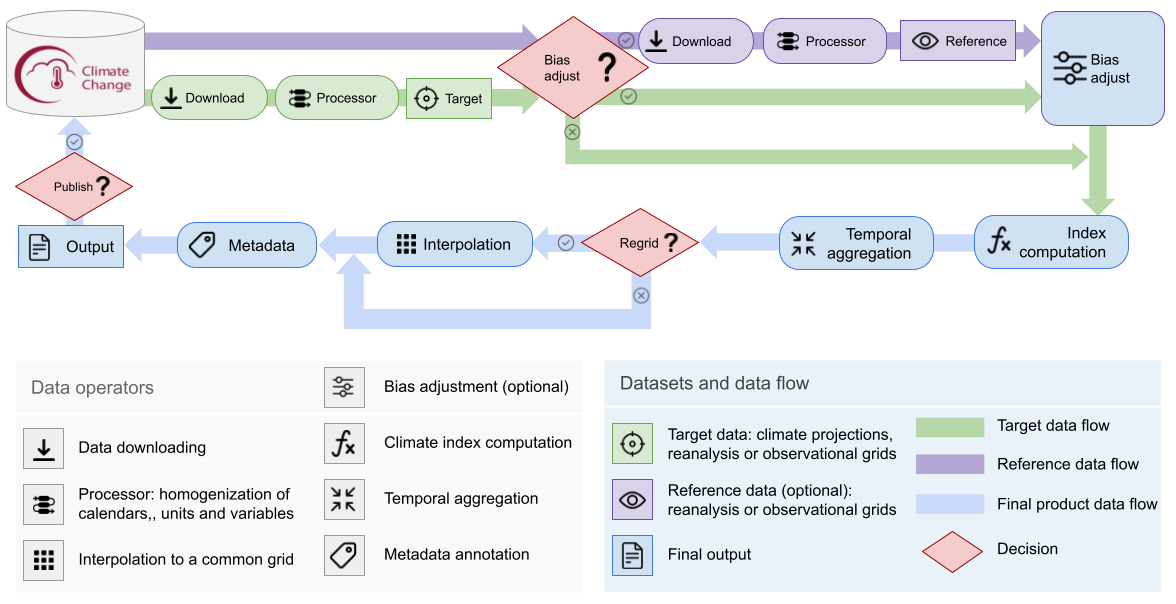

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Values of climate indicators (here 3 monthly indicators) provided by the Gridded dataset underpinning the Copernicus Interactive Climate Atlas are highly consistent with values calculated from its origin datasets (here 10 different datasets). The general distribution of indicator values is the same across time and space. However, small differences exist due to the difference in grid, as well as large differences in coverage in specific cases (e.g. sea surface temperature in polar regions). Users of the Atlas dataset – and thus users of the Atlas application – should be aware that values retrieved from Atlas may differ from a manual analysis of the origin dataset.
* The Atlas dataset is highly reproducible from its origins. The indicator values provided by the Atlas dataset are identical or very close to those resulting from a manual reprocessing of its origin datasets. Out of the indicator-origin pairs tested here, only SST-CCI sea surface temperature consistently shows differences, albeit minor ones, between Atlas and the origin. Furthermore, there are some differences in coverage (e.g. E-OBS). These differences should not affect most users of the Atlas dataset or application in most use cases. For further analysis, it is recommended to manually process the origin dataset.
```

## 📋 Methodology
This quality assessment tests the consistency between climate indicators retrieved from the [_Gridded dataset underpinning the Copernicus Interactive Climate Atlas_](https://doi.org/10.24381/cds.h35hb680) [[AtlasData](https://doi.org/10.24381/cds.h35hb680)] and their equivalents calculated from the origin datasets,
as well as the reproducibility of said dataset.

This notebook probes the consistency between the Atlas dataset and multiple origin datasets at the same time.
Due to differences in scope (e.g. atmosphere / land / sea), not every indicator is available in every origin dataset or its Atlas derivative.
Furthermore, some origin datasets are historical while others are future projections.
For this reason, we will examine the following indicators in the following origin datasets:

**Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C (`tx35`)**
| Type               | Dataset      |
|--------------------|--------------|
| Climate Projection | CMIP6        |
| Climate Projection | CMIP5        |
| Climate Projection | CORDEX-EUR-11|
| Reanalysis         | ERA5         |
| Reanalysis         | ERA5-Land    |
| Observations       | E-OBS        |
| Observations       | BERKEARTH    |

Note that CORDEX-CORE has been left out of this assessment because its mosaicking workflow is out of scope.
CERRA has been left out because the C3S User-tools package is currently not fully compatible with this dataset.

**Monthly mean temperature of sea water near the surface (`sst`)**
| Type               | Dataset      |
|--------------------|--------------|
| Reanalysis         | ORAS5        |
| Observations       | SST-CCI      |

**Monthly count of days with daily accumulated precipitation of liquid water equivalent from all phases above 1 mm (`r01`)**
| Type               | Dataset      |
|--------------------|--------------|
| Observations       | CPC          |

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](section-codesetup)**
 * Install User-tools for the C3S Atlas.
 * Import all required libraries.
 * Definition of helper functions.

**[](section-indicators)**
 * Download data from the origin datasets.
 * Homogenise data.
 * Calculate indicators.
 * Interpolate to a common and regular grid.
 * Download corresponding data from the Atlas dataset.

**[](section-results)**
 * Consistency: Compare the Atlas and reproduced datasets on native grids.
 * Reproducibility: Compare the Atlas and reproduced datasets on the Atlas grid.

## 📈 Analysis and results

(section-codesetup)=
### 1. Code setup
```{note}
This notebook uses [earthkit](https://github.com/ecmwf/earthkit) for 
downloading ([earthkit-data](https://github.com/ecmwf/earthkit-data)) 
and visualising ([earthkit-plots](https://github.com/ecmwf/earthkit-plots)) data.
Because earthkit is in active development, some functionality may change after this notebook is published.
If any part of the code stops functioning, please raise an issue on our GitHub repository so it can be fixed.
```

#### Install the User-tools for the C3S Atlas
This notebook uses the [User-tools for the C3S Atlas](https://github.com/ecmwf-projects/c3s-atlas), which can be installed from GitHub using `pip`.
For convenience, the following cell can do this from within the notebook.
Further details and alternative options for installing this library are available in its [documentation](https://github.com/ecmwf-projects/c3s-atlas?tab=readme-ov-file#requirements).

In [1]:
!pip install git+https://github.com/ecmwf-projects/c3s-atlas.git

  Cloning https://github.com/ecmwf-projects/c3s-atlas.git to /tmp/pip-req-build-71dpwogk
  Running command git clone --filter=blob:none --quiet https://github.com/ecmwf-projects/c3s-atlas.git /tmp/pip-req-build-71dpwogk
  Resolved https://github.com/ecmwf-projects/c3s-atlas.git to commit 80256810cb81aa78ab53033479e08cff6a8add44
  Preparing metadata (setup.py) ... done


#### Import required libraries
In this section, we import all the relevant packages needed for running the notebook.

In [2]:
# Input / Output
from pathlib import Path
import earthkit.data as ekd
import warnings

# General data handling
import numpy as np
np.seterr(divide="ignore")  # Ignore divide-by-zero warnings
import pandas as pd
import xarray as xr
from functools import partial, wraps
from dask.array import nanmedian, ravel
from dask.array.core import PerformanceWarning
warnings.simplefilter(action="ignore", category=PerformanceWarning)

# Data pre-processing
from c3s_atlas.fixers import apply_fixers
import c3s_atlas.interpolation as xesmfCICA
from datetime import datetime
from itertools import batched

# Climate indicators
import xclim
xclim.set_options(cf_compliance="log")  # Mute warnings
import c3s_atlas.indexes
from c3s_atlas.units import VALID_UNITS

# Visualisation
import earthkit.plots as ekp
from earthkit.plots.styles import Style
import matplotlib.pyplot as plt
plt.rcParams["grid.linestyle"] = "--"
from tqdm import tqdm  # Progress bars

# Visualisation in Jupyter book -- automatically ignored otherwise
try:
    from myst_nb import glue
except ImportError:
    glue = None

#### Define indicators

In [3]:
from typing import Callable
def propagate_nan(func: Callable) -> Callable:
    """ Decorator that ensures propagation of NaNs: find them in the original data, create a mask, and apply it to the result. """
    @wraps(func)
    def func_with_nan(ds: xr.Dataset, *args, propagate_nan=True, **kwargs) -> xr.Dataset:
        # Calculate indicator as normal
        indicator = func(ds, *args, **kwargs)

        # If propagation is not desired (e.g. you know there are no NaNs), simply return the result
        # This preserves integer data types
        if not propagate_nan:
            return indicator
        
        # Infer input (var-iable), output (ind-icator) keys
        var = list(ds.data_vars.keys())[0]
        ind = list(indicator.data_vars.keys())[0]

        # Resample data to frequency of indicator, generate mask
        freq = xr.infer_freq(indicator["time"])
        mask = ds.notnull()                  \
                 .resample({"time": freq})   \
                 .sum()                      \
                 .astype(bool)               \
                 .rename({var: ind})

        # Apply mask and return result
        indicator_masked = indicator.where(mask, np.nan)
        return indicator_masked

    return func_with_nan

In [4]:
def cal_tasmax(ds: xr.Dataset, *, key: str=None) -> xr.Dataset:
    """ Daily maximum of hourly temperature """
    ds_tx = data.resample(valid_time="1D").max()
    if key:
        ds_tx = ds_tx.rename({key: "tasmax"})
    return ds_tx

@propagate_nan
def cal_tx35(ds: xr.Dataset) -> xr.Dataset:
    """ Monthly count of days with maximum near-surface (2-metre) temperature above 35 °C """
    ds_tx35 = xclim.indices.tx_days_above(ds['tasmax'], thresh='35.0 degC', freq='MS', op='>').to_dataset(name='tx35')
    return ds_tx35

def cal_sst(ds: xr.Dataset) -> xr.Dataset:
    """ Monthly mean temperature of sea water near the surface """
    ds_sst = ds['sst'].resample(time='MS').mean().to_dataset(name='sst')
    return ds_sst

@propagate_nan
def cal_r01(ds: xr.Dataset) -> xr.Dataset:
    """ Monthly count of days with daily accumulated precipitation of liquid water equivalent from all phases above 1 mm """
    pr_flux = ds['pr'].copy().assign_attrs(units = 'mm/day')
    per0 = xr.zeros_like(pr_flux).assign_attrs(units='mm/day')
    ds_r01 = xclim.indices.days_over_precip_thresh(pr_flux, per0, thresh='1 mm/day', freq='MS', bootstrap=False, op='>').to_dataset(name='r01')
    return ds_r01

In [5]:
# Styles for indicators
n_diff = 5  # Levels in difference charts

_style_monthly_days      = {"vmin": 0,     "vmax": 30,    "extend": "neither"}
_style_monthly_days_diff = {"vmin": -2.5,  "vmax": 2.5,   "extend": "both"}

# tx35 indicator
_style_tx35      = _style_monthly_days      | {"cmap": plt.cm.Oranges.resampled(10)}
_style_tx35_diff = _style_monthly_days_diff | {"cmap": plt.cm.RdBu_r.resampled(n_diff)}

# sst indicator
_style_sst        = {"cmap": plt.cm.YlOrBr.resampled(14),   "vmin": -5, "vmax": 30, "extend": "both"}
_style_sst_diff   = {"cmap": plt.cm.RdBu.resampled(n_diff), "vmin": -1, "vmax": 1,  "extend": "both"}

# r01 indicator
_style_r01         = _style_monthly_days      | {"cmap": plt.cm.Blues.resampled(10)}
_style_r01_diff    = _style_monthly_days_diff | {"cmap": plt.cm.RdBu.resampled(n_diff)}

# Individual styles
# Set up like this so they can still be edited individually
styles = {
    "tx35": Style(**_style_tx35),       "tx35_diff": Style(**_style_tx35_diff),
    "sst" : Style(**_style_sst),        "sst_diff": Style(**_style_sst_diff),
    "r01": Style(**_style_r01),         "r01_diff": Style(**_style_r01_diff),
}

# Apply general settings
for style in styles.values():
    style.normalize = False

#### Helper functions

##### General

In [6]:
# Type hints
from typing import Iterable, Optional
from earthkit.plots.geo.domains import Domain
AnyDomain = (Domain | str)

##### Downloading data

In [7]:
# Split requests into smaller parts
def split_request_along_key(request: dict, key: str) -> list[dict]:
    """ Given a dict `request` with iterable entries, for the given `key`, generate a list of dicts instead. """
    return [request | {key: [item,]} for item in request[key]]

# Select (multiple) years in a dataset
def select_years_in_dataset(data: xr.Dataset, years: Iterable[int | str]) -> xr.Dataset:
    """ Select only data for the given year(s). """
    years = [years,] if (isinstance(years, str) or not isinstance(years, Iterable)) else years  # Deal with single year
    years_int = [int(y) for y in years]
    return data.sel(time=data.time.dt.year.isin(years_int))

# SST-CCI: Generate monthly batches of requests
def generate_dates_in_month(year: int, month: int) -> str:
    """ For a given year + month, generate all valid dates (checked with datetime). """
    year, month = int(year), int(month)
    for day in range(1, 32):
        try:  # Validate the date
            datetime(year, month, day)
        except ValueError:  # Invalid date
            continue
        else:  # Valid date
            yield f"{day:02}"  # 2-digit string format for CDS
    
def generate_monthly_batches(year: int, month: int, *, n=11):
    """ Generate batches of n days in the given year + month. """
    yield from batched(generate_dates_in_month(year, month), n)

def create_submonthly_request(main_request: dict, month: str, day_batch: Iterable[str]) -> dict:
    """
    Add a month and day (or batch of days) to a `main_request`.
    Note that month and day_batch must be in 2-digit string format for the CDS to accept them.
    """
    request = {
        "month": month,
        "day": day_batch,
    } | main_request
    return request

def generate_submonthly_requests(main_request: dict, year: str, *, n=11) -> list[dict]:
    """ For a given `year`, generate batched requests of n days per month for every month. """
    year = int(year)

    # Generate requests
    return [create_submonthly_request(main_request, month, day_batch) 
            for month in MONTHS  # Requires MONTHS to be defined in the "general setup" section
            for day_batch in generate_monthly_batches(year, month, n=n)]

In [8]:
# Atlas dataset: Individual model selection
def select_model_from_atlas_dataset(data: xr.Dataset, model: str) -> xr.Dataset:
    """ Select only data for the given model. """
    # Ensure the model ID is provided in the right format
    model_id = model.replace("_", "-").lower()

    # Find the corresponding model ID in the list of models
    # This cannot use .sel because the coordinate is not indexed
    select_member = [str(mem) for mem in data.member_id.values if model_id in mem.replace("_", "-").lower()][0]

    # Find the corresponding data and return those
    member_ind = np.where(data.member_id == select_member)[0]
    data_member = data.sel(member=member_ind).squeeze("member")

    return data_member

# Atlas dataset: Common pre-processing
def preprocess_atlas_data(data: xr.Dataset, years: str | Iterable[str], model: Optional[str]=None) -> xr.Dataset:
    """ Pre-process Atlas data by selecting only the desired years and model (if relevant). """
    data = select_years_in_dataset(data, years)
    if model:
        data = select_model_from_atlas_dataset(data, model)

    return data

##### Data (pre-)processing

In [9]:
# Rechunking of data to speed up dask calculations
def rechunk(ds: xr.Dataset) -> xr.Dataset:
    """ Rechunk a dataset `ds` based on pre-set memory requirements. """
    # Find coordinates (usually lat/lon, sometimes x/y)
    index_keys = ds.indexes.keys()
    coord_keys = [key for key in index_keys if key != "time"]

    # Assign new chunk sizes
    if ds.nbytes <= 1e8:  # 100 MB
        chunks = {"time": -1} | {coord: -1 for coord in coord_keys}
    else:
        chunks = {"time": 2}  | {coord: 4000 for coord in coord_keys}
    return ds.chunk(chunks)

In [10]:
# Homogenisation of origin dataset
def homogenise(ds: xr.Dataset, var_name: str, project_id: str) -> xr.Dataset:
    """ Homogenise a dataset `ds` for one variable `var_name` """
    var_mapping = {
                "dataset_variable": {var_name: "data"},
                "aggregation": {"data": "mean"},
        }
    data = apply_fixers(ds, var_name, project_id, var_mapping)
    return data

In [11]:
def padded_range(start: float, stop: float, step: float) -> tuple[float]:
    """ Given a range, e.g. (-89.5, 89.5, 1.), create a padded np.arange that includes the stop. """
    stop = stop + step/100.
    return np.arange(start, stop, step)

# Interpolation from native grid to Atlas grid
def interpolate(ds: xr.Dataset, var_name: str, *,
                lat_range: Iterable[float]=(-89.5, 89.5, 1.), lon_range: Iterable[float]=(-179.5, 179.5, 1.)) -> xr.Dataset:
    """ Interpolates a dataset `ds` for one variable `var_name`. """
    int_attr = {"interpolation_method": "conservative_normed",
                "lats": padded_range(*lat_range),
                "lons": padded_range(*lon_range),
                "var_name": var_name,
    }
    INTER = xesmfCICA.Interpolator(int_attr)
    ds_interp = INTER(ds)
    return ds_interp

def interpolate_sst(ds: xr.Dataset, var_name: str, *,
                    lats: np.ndarray, lons: np.ndarray) -> xr.Dataset:
    """ Interpolates a dataset `ds` for one variable `var_name`. Accepts any lat/lon range. """
    int_attr = {"interpolation_method": "conservative_normed",
                "lats": lats,
                "lons": lons,
                "var_name": var_name,
    }
    INTER = xesmfCICA.Interpolator(int_attr)
    ds_interp = INTER(ds)
    return ds_interp

##### Statistics

In [12]:
## Statistics
# Constants
NONZERO_THRESHOLD = 1e-5
NONZERO_THRESHOLD_PCT = 0.1

# Difference between datasets
def difference_between_datasets(data1: xr.Dataset, data2: xr.Dataset, diff_variables: Iterable[str]) -> xr.Dataset:
    """ Calculate the difference between two datasets, preserving CRS and metadata. """
    # Align
    data1, data2 = xr.align(data1, data2, join="inner", copy=False)
    
    # Subtract
    data1, data2 = [d.drop_vars(["lat_bnds", "lon_bnds", "time_bnds", "height"], errors="ignore") for d in (data1, data2)]
    difference = xr.ufuncs.subtract(data1[diff_variables], data2[diff_variables])
    return difference

def relative_difference_between_datasets(data1: xr.Dataset, data2: xr.Dataset, reldiff_variables: Iterable[str]) -> xr.Dataset:
    """
    Calculate the relative [%] difference between two datasets, preserving CRS and updating metadata.
    Relative difference is calculated relative to the first dataset.
    Where data1 == 0 and data2 == 0, the relative difference is set to 0 too.
    """
    # Select and calculate
    data1, data2 = [dataset.drop_vars([var for var in dataset.data_vars if var not in [*reldiff_variables, "crs"]]) \
                        for dataset in (data1, data2)]

    relative_difference = (data1 - data2) / data1 * 100.

    # Replace 0/0 with 0
    data1_zero = (data1 <= NONZERO_THRESHOLD)  # Threshold slightly > 0 because of floating-point errors
    relative_difference = relative_difference.where(~data1_zero, 0.)

    # Add name
    relative_difference = relative_difference.assign_attrs({"name": "Atlas – Reproduced [%]"})

    return relative_difference

def fraction_over_threshold(data: pd.DataFrame, threshold: float=NONZERO_THRESHOLD) -> pd.DataFrame:
    """ Calculate the % of non-NaN cells in a dataframe greater than a given threshold. """
    data_over = (data >= threshold)
    frac_over = data_over.sum() / data_over.count() * 100.
    return frac_over

fraction_over_threshold_relative = partial(fraction_over_threshold, threshold=NONZERO_THRESHOLD_PCT)

In [13]:
def _comparison_statistics_single(dataset1: xr.Dataset, dataset2: xr.Dataset, indicator: str, *,
                                  do_relative=False) -> pd.DataFrame:
    """
    Given two datasets, calculate a number of statistics for one variable and return the result in a table.
    This version is hardcoded for one indicator in one year.
    Run this multiple times in a loop to do multiple origins.
    """
    # Calculate differences
    differences = difference_between_datasets(dataset1, dataset2, diff_variables=[indicator,])
    differences_abs = xr.ufuncs.abs(differences)

    # Calculate relative difference if desired
    if do_relative:
        differences_rel = relative_difference_between_datasets(dataset1, dataset2, reldiff_variables=[indicator,])
        differences_rel_abs = xr.ufuncs.abs(differences_rel)

    # Calculate aggregate statistics
    # (n.b. in dask, this only queues them up, doesn't actually compute)
    stats = {r"Mean Δ": differences[indicator].mean(),
             r"Median Δ": nanmedian(ravel(differences[indicator]), axis=0),
             r"Median |Δ|": nanmedian(ravel(differences_abs[indicator]), axis=0),
             r"% where |Δ| ≥ ε": fraction_over_threshold(differences_abs[indicator]),
            }

    if do_relative:
        stats_rel = {r"Median |Δ| [%]": nanmedian(ravel(differences_rel_abs[indicator]), axis=0),
                     rf"% where |Δ| ≥ {NONZERO_THRESHOLD_PCT}%": fraction_over_threshold_relative(differences_rel_abs[indicator]),
                    }
        stats = stats | stats_rel

    # Calculate correlation coefficients
    corrs = {r"Pearson r": xr.corr(dataset1[indicator], dataset2[indicator])}
    stats = stats | corrs

    # Perform the queued-up calculations
    stats = {key: float(stat) for key, stat in stats.items()}

    # Combine statistics into one dataframe
    stats = pd.DataFrame.from_dict({indicator: stats}, orient="index")

    return stats

def comparison_statistics(dataset1: xr.Dataset, dataset2: xr.Dataset, indicator: str, *,
                          do_relative=False) -> pd.DataFrame:
    """
    Given two dicts of datasets, calculate a number of statistics for one variable and return the result in a table.
    This version is hardcoded for one indicator, one year, multiple datasets.
    """
    # Setup: origins
    common_keys = [k for k in dataset1 if k in dataset2]
    loop_origins = tqdm(common_keys, desc="Calculating for datasets", leave=False)

    # Calculate statistics per dataset, combine result, return
    stats = [_comparison_statistics_single(dataset1[key], dataset2[key], indicator, do_relative=do_relative).rename(index={indicator: key})
             for key in loop_origins]
    stats = pd.concat(stats, axis=0)

    return stats

def display_difference_stats(dataset1: dict, dataset2: dict, *args,
                             glue_label: Optional[str]=None, **kwargs) -> str:
    """ Given two dicts of datasets, calculate a number of statistics for each pair and display the result in a table. """
    comparison_stats = comparison_statistics(dataset1, dataset2, *args, **kwargs)
    formatted = comparison_stats.style \
                                .format(precision=5)  \
                                .set_caption("Atlas – Reproduced")
    return formatted

##### Visualisation

In [14]:
# Visualisation: Helper functions, general
def _glue_or_show(fig: plt.Figure, glue_label: Optional[str]=None) -> None:
    """
    If `glue` is available, glue the figure using the provided label.
    If not, display the figure in the notebook.
    """
    try:
        glue(glue_label, fig, display=False)
    except TypeError:
        plt.show()
    finally:
        plt.close()

def _add_textbox_to_subplots(text: str, *axs: Iterable[plt.Axes | ekp.Subplot], right=False) -> None:
    """ Add a text box to each of the specified subplots. """
    # Get the plt.Axes for each ekp.Subplot
    axs = [subplot.ax if isinstance(subplot, ekp.Subplot) else subplot for subplot in axs]

    # Set up location
    x = 0.95 if right else 0.05
    horizontalalignment = "right" if right else "left"

    # Add the text
    for ax in axs:
        ax.text(x, 0.95, text, transform=ax.transAxes,
        horizontalalignment=horizontalalignment, verticalalignment="top",
        bbox={"facecolor": "white", "edgecolor": "black", "boxstyle": "round",
              "alpha": 1})

def _sharexy(axs: np.ndarray) -> None:
    """ Force all of the axes in axs to share x and y with the first element. """
    main_ax = axs.ravel()[0]
    for ax in axs.ravel():
        ax.sharex(main_ax)
        ax.sharey(main_ax)

def _symmetric_xlim(ax: plt.Axes) -> None:
    """ Adjust the xlims for one Axes to be symmetric, based on existing values. """
    current = ax.get_xlim()
    current = np.abs(current)
    maxlim = np.max(current)
    newlim = (-maxlim, maxlim)

    ax.set_xlim(newlim)

In [15]:
# Visualisation: Helper functions for geospatial plots
def _spatial_plot_append_subplots(fig: ekp.Figure, *data: xr.Dataset, domain: Optional[AnyDomain]=None, **kwargs) -> list[ekp.Subplot]:
    """ Plot any number of datasets into new subplots in an existing earthkit figure. """
    # Create subplots
    subplots = [fig.add_map(domain=domain) for d in data]

    # Plot
    for subplot, d in zip(subplots, data):
        subplot.grid_cells(d, x="lon", y="lat", **kwargs)

    return subplots

In [16]:
def geospatial_comparison_multiple_origins(data1: dict[str, xr.Dataset], data2: dict[str, xr.Dataset], indicator: str, date: str, *,
                                           label1: str="Atlas dataset", label2: str="Reproduced from origin",
                                           domain: Optional[str | Domain]=None,
                                           glue_label: Optional[str]=None) -> None:

    """
    Plot one indicator in multiple dicts of datasets.
    A specific date (e.g. year+month as "2010-06") has to be specified.
    """
    # Setup: origins
    common_keys = [k for k in data1 if k in data2]
    n_datasets = len(common_keys)
    loop_origins = tqdm(common_keys, desc="Plotting datasets", leave=False)
    
    # Create figure
    fig = ekp.Figure(rows=n_datasets, columns=2, size=(7.5, max(5, 3*n_datasets)))
    
    for key in loop_origins:
        data1_here, data2_here = [d[key].sel(time=date, method="nearest") for d in (data1, data2)]

        # Plot individual datasets
        subplots_data = _spatial_plot_append_subplots(fig, data1_here, data2_here, domain=domain,
                                                      z=indicator, style=styles[indicator])

        # Decorate: Text
        _add_textbox_to_subplots(f"{key} ({date})", *subplots_data)

    # Colour bar at the bottom
    for subplot in fig.subplots[-2:]:
        subplot.legend(label=indicator, location="bottom")

    # Titles on top
    titles = [label1, label2]
    for title, subplot in zip(titles, fig.subplots):
        subplot.ax.set_title(title)

    # Decorate figure
    fig.land()
    fig.coastlines()
    fig.gridlines(linestyle=plt.rcParams["grid.linestyle"])
    
    # Show result
    _glue_or_show(fig.fig, glue_label)

In [17]:
# Visualisation: Plot indicators geospatially
def geospatial_comparison_multiple_origin_with_difference(data1: dict, data2: dict, indicator: str, date: str, *,
                                                          label1: str="Atlas dataset", label2: str="Reproduced from origin",
                                                          domain: Optional[str | Domain]=None,
                                                          glue_label: Optional[str]=None) -> None:
    """
    Plot one indicator in multiple dicts of datasets.
    A specific date (e.g. year+month as "2010-06") has to be specified.
    """
    # Setup: origins
    common_keys = [k for k in data1 if k in data2]
    n_datasets = len(common_keys)
    loop_origins = tqdm(common_keys, desc="Plotting datasets", leave=False)

    # Create figure
    fig = ekp.Figure(rows=n_datasets, columns=3, size=(7.5, max(5, 2*n_datasets)))
    
    for key in loop_origins:
        data1_here, data2_here = [d[key].sel(time=date, method="nearest") for d in (data1, data2)]
        difference = difference_between_datasets(data1_here, data2_here, diff_variables=[indicator,])
  
        # Plot individual datasets
        subplots_data = _spatial_plot_append_subplots(fig, data1_here, data2_here, domain=domain, 
                                                      z=indicator, style=styles[indicator])

        # Plot difference
        subplot_diff = fig.add_map(domain=domain)
        subplot_diff.grid_cells(difference, z=indicator, style=styles[f"{indicator}_diff"])
    
        # Decorate: Text
        _add_textbox_to_subplots(f"{key} ({date})", *subplots_data, subplot_diff)

    # Colour bar at the bottom
    for subplot in subplots_data:
        subplot.legend(label=indicator, location="bottom")
    subplot_diff.legend(label="Difference", location="bottom")

    
    # Titles on top
    titles = [label1, label2, "Difference"]
    for title, subplot in zip(titles, fig.subplots):
        subplot.ax.set_title(title)

    # Decorate figure
    fig.land()
    fig.coastlines()
    fig.gridlines(linestyle=plt.rcParams["grid.linestyle"])
    
    # Show result
    _glue_or_show(fig.fig, glue_label)

In [18]:
# Visualisation: Plot data in histograms
def histogram_comparison_by_origin(data1: dict, data2: dict, indicator: str, *,
                                   label1: str="Atlas dataset", label2: str="Reproduced from origin",
                                   year: Optional[str]="", log=False,
                                   glue_label: Optional[str]=None) -> None:
    """
    Plot a histogram for one indicator in multiple dicts of datasets.
    Flattens all data in the datasets, including spatial and temporal dimensions.
    """
    # Setup: origins
    common_keys = [k for k in data1 if k in data2]
    n_datasets = len(common_keys)
    loop_origins = tqdm(common_keys, desc="Plotting datasets", leave=False)

    # Create figure
    fig, axs = plt.subplots(nrows=n_datasets, ncols=2, sharex="row", sharey="row",
                            figsize=(5, 2*n_datasets), layout="constrained", squeeze=False)

    # Plot histograms of data
    # Loop over rows / origins
    for ax_row, key in zip(axs, loop_origins):
        data1_here, data2_here = data1[key], data2[key]

        for ax, data in zip(ax_row, (data1_here, data2_here)):
            # Flatten data
            d = data[indicator].values.ravel()

            # Create histogram
            ax.hist(d, bins=31, density=True, log=log, color="black")

            # Labels
            ax.grid(True, axis="both")
            ax.set_xlabel(indicator)

        ax_row[0].set_ylabel("Frequency")

        # Identify panel
        date_label = f" ({year})" if year else ""
        _add_textbox_to_subplots(f"{key}{date_label}", *ax_row, right=True)

    # Titles on top
    titles = [label1, label2]
    for title, ax in zip(titles, axs[0]):
        ax.set_title(title)

    # Show result
    _glue_or_show(fig, glue_label)

In [19]:
# Visualisation: Plot data + difference in histograms
def histogram_comparison_by_origin_with_difference(data1: dict, data2: dict, indicator: str, *,
                                                   label1: str="Atlas dataset", label2: str="Reproduced from origin",
                                                   year: Optional[str]="", log=False,
                                                   glue_label: Optional[str]=None) -> None:
    """
    Plot a histogram for one indicator in multiple dicts of datasets, including the point-by-point difference.
    Flattens all data in the datasets, including spatial and temporal dimensions.
    """
    # Setup: origins
    common_keys = [k for k in data1 if k in data2]
    n_datasets = len(common_keys)
    loop_origins = tqdm(common_keys, desc="Plotting datasets", leave=False)

    # Create figure
    fig, axs = plt.subplots(nrows=n_datasets, ncols=3,
                            figsize=(8, 2*n_datasets), layout="constrained", squeeze=False)

    # Setup x/y share -- cannot be done in plt.subplots because of difference panel not sharing these
    _sharexy(axs[:, :-1])
    # _sharexy(axs[:, -1])  # Leave out for now -- ALlow differences between origin datasets

    for ax in axs[:-1, :-1].ravel():
        ax.tick_params(axis="x", labelbottom=False)
        ax.xaxis.label.set_visible(False)

    for ax in axs[:, 1:-1].ravel():
        ax.tick_params(axis="y", labelleft=False)

    for ax in axs[:, -1].ravel():
        ax.yaxis.set_label_position("right")
        ax.tick_params(axis="y", labelleft=False, labelright=True)

    # Plot histograms of data
    # Loop over rows / origins
    for ax_row, key in zip(axs, loop_origins):
        data1_here, data2_here = data1[key], data2[key]
        difference = difference_between_datasets(data1_here, data2_here, diff_variables=[indicator,])

        # Loop over columns / data
        for ax, data in zip(ax_row, (data1_here, data2_here)):
            # Flatten data
            d = data[indicator].values.ravel()

            # Create histogram
            ax.hist(d, bins=31, density=True, log=log, color="black")

            # Labels
            ax.grid(True, axis="both")
            ax.set_xlabel(indicator)

            # Plot difference
            difference_here = difference[indicator].values.ravel()
            ax_row[-1].hist(difference_here, bins=31, density=True, log=log, color="black")

        ax_row[0].set_ylabel("Frequency")

        # Identify panel
        date_label = f" ({year})" if year else ""
        _add_textbox_to_subplots(f"{key}{date_label}", *ax_row, right=True)

    for ax in axs[:, -1]:  # Symmetric xlims for difference
        _symmetric_xlim(ax)

    # Titles on top
    titles = [label1, label2, "Difference"]
    for title, ax in zip(titles, axs[0]):
        ax.set_title(title)

    # Show result
    _glue_or_show(fig, glue_label)

(section-indicators)=
### 2. Calculate and retrieve indicators
In the previous two notebooks in this assessment,
the origin data were downloaded,
pre-processed,
used to calculate the relevant indicator(s),
and interpolated;
after which the [Atlas dataset](https://doi.org/10.24381/cds.h35hb680) was downloaded.
This notebook follows the same structure but for each origin in turn,
for clarity and to preserve memory when loading multiple datasets at the same time.
As such,
the individual steps are described in less detail,
because this information is available in the previous notebooks.

If you are only interested in specific origin datasets,
or want to limit your bandwidth or memory usage,
you can choose to only run specific subsections below.

This notebook uses [earthkit-data](https://github.com/ecmwf/earthkit-data) to download files from the CDS.
If you intend to run this notebook multiple times, it is highly recommended that you [enable caching](https://earthkit-data.readthedocs.io/en/latest/guide/caching.html) to prevent having to download the same files multiple times.

```{note}
This notebook uses [xESMF](https://github.com/pangeo-data/xESMF) for regridding data.
xESMF is most easily installed using mamba/conda as explained in its documentation.
Users who cannot or do not wish to use mamba/conda can manually compile and install [ESMF](https://earthsystemmodeling.org/docs/release/latest/ESMF_usrdoc/node10.html) on their machines.
In future, this notebook will use [earthkit-regrid](https://github.com/ecmwf/earthkit-regrid) instead, once it reaches suitable maturity.
```

Note that the Atlas workflow calculates indicators first, then regrids.
For operations that involve averaging, like smoothing and regridding, the order of operations can affect the result, especially in areas with steep gradients [[Bur20](https://doi.org/10.1364/OE.391470)].
Examples of such areas for a temperature index are coastlines and mountain ranges.
In the case of Atlas, this order of operations was a conscious choice to preserve the "raw" signals,
e.g. preventing extreme temperatures from being smoothed out.
However, it can affect the indicator values and therefore must be considered when using the Atlas application or dataset.

#### General setup
Throughout this section,
we combine the downloaded datasets into dictionaries for easy access.
They cannot be combined into a single xarray object because of differing grids.
Each dataset is added in its own subsection,
meaning any datasets not downloaded will automatically be skipped in the analysis.

In [20]:
# Constants to ensure consistency between origins
# Change these to customise the analysis
YEAR_HISTORICAL = "2010"
YEAR_FUTURE     = "2080"

# All days and months
MONTHS  = [f"{month:02d}" for month in range(1, 13)]
DAYS    = [f"{day:02d}"   for day   in range(1, 32)]
HOURS24 = [f"{h:02}:00"   for h     in range(24)]

In [21]:
# Setup: Atlas request
ATLAS_ID = "multi-origin-c3s-atlas"
BIAS_ADJUSTMENT = "no_bias_adjustment"

# Templates for Atlas requests
request_atlas_tx35 = {
    "variable": "monthly_extreme_hot_days",
    "bias_adjustment": BIAS_ADJUSTMENT,
}

request_atlas_sst = {
    "variable": "monthly_sea_surface_temperature",
    "bias_adjustment": BIAS_ADJUSTMENT,
    "domain": "global",
}

request_atlas_r01 = {
    "variable": "monthly_wet_days",
    "bias_adjustment": BIAS_ADJUSTMENT,
}

In [22]:
atlas_tx35_future                = {}
origin_tx35_future               = {}
origin_atlasgrid_tx35_future     = {}

atlas_tx35_historical            = {}
origin_tx35_historical           = {}
origin_atlasgrid_tx35_historical = {}

atlas_sst                        = {}
origin_sst                       = {}
origin_atlasgrid_sst             = {}

atlas_r01                        = {}
origin_r01                       = {}
origin_atlasgrid_r01             = {}

#### CMIP6

In [23]:
# Setup: Customisable options for this dataset
CMIP6_MODEL = "cmcc_esm2"
CMIP6_EXPERIMENT = "ssp5_8_5"

In [24]:
# Setup: Origin request
CMIP6_ID = "projections-cmip6"
request_CMIP6 = {
    "temporal_resolution": "daily",
    "experiment": CMIP6_EXPERIMENT,
    "model": CMIP6_MODEL,
    "variable": ["daily_maximum_near_surface_air_temperature"],
    "year": [YEAR_FUTURE,],
    "month": MONTHS,  
    "day": DAYS,
    "format": "netcdf",
}

# Download data, pre-process, calculate indicator, interpolate
data = ekd.from_source("cds", CMIP6_ID, request_CMIP6).to_xarray()
data = homogenise(data, "tasmax", CMIP6_ID)
indicator_CMIP6 = cal_tx35(data, propagate_nan=False)
interpolated_CMIP6 = interpolate(indicator_CMIP6, "tx35",
                                 lat_range=(-89.5, 89.5, 1), lon_range=(-179.5, 179.5, 1))

Unknown file type, no reader available. path=/home/ob2/cds_data/cds-67885792c67c919c6adef8f9452ca11327458aa2fc79e661bd6835af4bbb1791.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\n\xd3\x00\x00\x03"\x08\x02\x00\x00\x00\x99\xec9+\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddw' content_type=None
2025-10-13 13:22:16,415 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2025-10-13 13:22:16,422 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 81MB
Dimensions:    (time: 365, bnds: 2, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 3kB 2080-01-01 12:00:00 ... 2080-12-31 12:00:00
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) ob

In [25]:
# Setup: Atlas request
request_atlas_cmip6 = {
    "origin": "cmip6",
    "experiment": CMIP6_EXPERIMENT,
    "domain": "global",
    "period": [YEAR_FUTURE,],
} | request_atlas_tx35

# Download data, pre-process
data_atlas = ekd.from_source("cds", ATLAS_ID, request_atlas_cmip6).to_xarray()
data_atlas = preprocess_atlas_data(data_atlas, YEAR_FUTURE, CMIP6_MODEL)

Unknown file type, no reader available. path=/home/ob2/cds_data/cds-b5aaa11592ca0d2fd397548b5aa106f70d92ac1a815c9807e35b1ba95a53498d.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08\xf5\x00\x00\x03\x10\x08\x02\x00\x00\x00\xcaqU\xdb\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddw' content_type=None
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [26]:
# Add to collection
atlas_tx35_future["CMIP6"]            = data_atlas
origin_tx35_future["CMIP6"]           = indicator_CMIP6
origin_atlasgrid_tx35_future["CMIP6"] = interpolated_CMIP6

#### CMIP5

In [27]:
# Setup: Customisable options for this dataset
CMIP5_MODEL = "access1_0"
CMIP5_MEMBER = "r1i1p1"
CMIP5_EXPERIMENT = "rcp_8_5"

In [28]:
# Setup: Origin request
CMIP5_ID = "projections-cmip5-daily-single-levels"
request_CMIP5 = {
    "experiment": CMIP5_EXPERIMENT,
    "variable": ["maximum_2m_temperature_in_the_last_24_hours"],
    "model": CMIP5_MODEL,
    "ensemble_member": CMIP5_MEMBER,
    # Note: CMIP5 "period" cannot be [YEAR_FUTURE,]
    # You may have to change the following line if you want to change
    # YEAR_FUTURE, CMIP5_MODEL, or CMIP5_EXPERIMENT
    "period": ["20560101-20801231"],
}

# Download data, pre-process, calculate indicator, interpolate
data = ekd.from_source("cds", CMIP5_ID, request_CMIP5).to_xarray()
data = select_years_in_dataset(data, [YEAR_FUTURE,])
data = homogenise(data, "tasmax", CMIP5_ID)
indicator_CMIP5 = cal_tx35(data)
interpolated_CMIP5 = interpolate(indicator_CMIP5, "tx35",
                                 lat_range=(-89., 89., 2), lon_range=(-179., 179., 2))

2025-10-13 13:22:24,747 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2025-10-13 13:22:24,752 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 41MB
Dimensions:    (time: 366, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2080-01-01T12:00:00 ... 2080-12-31T1...
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 6kB dask.array<chunksize=(366, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 2kB dask.array<chunksize=(145, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 41MB dask.array<chunksize=(366, 145, 192), meta=np.ndarray>
Attributes: (12/28)
   

In [29]:
# Setup: Atlas request
request_atlas_cmip5 = {
    "origin": "cmip5",
    "experiment": CMIP5_EXPERIMENT,
    "domain": "global",
    "period": [YEAR_FUTURE,],
} | request_atlas_tx35

# Download data, pre-process
data_atlas = ekd.from_source("cds", ATLAS_ID, request_atlas_cmip5).to_xarray()
data_atlas = preprocess_atlas_data(data_atlas, YEAR_FUTURE, CMIP5_MODEL)

Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attempt 1 of 500
Retrying in 120 seconds
Unknown file type, no reader available. path=/home/ob2/cds_data/cds-3c4af3bcd509d1bc684ea0a13a51efbf29798847ef1e4016f82a1078abf80a8c.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08\xea\x00\x00\x03\x10\x08\x02\x00\x00\x00\x1c\xd4\x8f\xbe\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddw' content_type=None
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+3

In [30]:
# Add to collection
atlas_tx35_future["CMIP5"]            = data_atlas
origin_tx35_future["CMIP5"]           = indicator_CMIP5
origin_atlasgrid_tx35_future["CMIP5"] = interpolated_CMIP5

#### CORDEX-EUR-11

In [31]:
# Setup: Customisable options for this dataset
# Note that the model nomenclature is differen for the origin dataset (GCM, RCM separate) vs Atlas (combined)
# If you want to change the model, be sure to edit all of the relevant lines below
CORDEX_EUR_11_GCM = "ncc_noresm1_m"
CORDEX_EUR_11_RCM = "gerics_remo2015"
CORDEX_EUR_11_MODEL = "NCC_NorESM1-M_r1i1p1_GERICS_REMO2015_v1"
CORDEX_EUR_11_MEMBER = "r1i1p1"
CORDEX_EUR_11_EXPERIMENT = "rcp_8_5"

In [32]:
# Setup: Origin request
CORDEX_EUR_11_ID = "projections-cordex-domains-single-levels"
request_CORDEX_EUR_11 = {
    "domain": "europe",
    "experiment": CORDEX_EUR_11_EXPERIMENT,
    "horizontal_resolution": "0_11_degree_x_0_11_degree",
    "temporal_resolution": "daily_mean",
    "variable": ["maximum_2m_temperature_in_the_last_24_hours"],
    "gcm_model": CORDEX_EUR_11_GCM,
    "rcm_model": CORDEX_EUR_11_RCM,
    "ensemble_member": CORDEX_EUR_11_MEMBER,
    # Note: CORDEX "start_year" and "end_year" cannot be YEAR_FUTURE
    # and cannot be determined generically for the various model members
    # You may have to change the following line if you want to change
    # YEAR_FUTURE, CORDEX_EUR_11_MODEL, or CORDEX_EUR_11_EXPERIMENT
    "start_year": ["2076"],
    "end_year": ["2080"],
}

# Download data, pre-process, calculate indicator, interpolate
data = ekd.from_source("cds", CORDEX_EUR_11_ID, request_CORDEX_EUR_11).to_xarray()
data = select_years_in_dataset(data, [YEAR_FUTURE,])
data = homogenise(data, "tasmax", CORDEX_EUR_11_ID)
indicator_CORDEX_EUR_11 = cal_tx35(data)
interpolated_CORDEX_EUR_11 = interpolate(indicator_CORDEX_EUR_11, "tx35",
                                         lat_range=(21.8125, 72.6875, 0.125), lon_range=(-44.8125, 65.1875, 0.125))

2025-10-13 13:25:27,949 — Homogenization-fixers — INFO — Fixing coordinates names: {'rlon': 'x', 'rlat': 'y'}
2025-10-13 13:25:27,953 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 263MB
Dimensions:                     (time: 366, bnds: 2, y: 412, x: 424, vertices: 4)
Coordinates:
  * time                        (time) datetime64[ns] 3kB 2080-01-01T12:00:00...
  * y                           (y) float64 3kB -23.38 -23.27 ... 21.72 21.84
  * x                           (x) float64 3kB -28.38 -28.27 ... 18.04 18.16
    lat                         (y, x) float32 699kB dask.array<chunksize=(412, 424), meta=np.ndarray>
    lon                         (y, x) float32 699kB dask.array<chunksize=(412, 424), meta=np.ndarray>
    height                      float64 8B ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds                   (time, bnds) datetime64[ns] 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    rotated_latitude_longi

In [33]:
# Setup: Atlas request
request_atlas_cordex_eur_11 = {
    "origin": "cordex_eur_11",
    "experiment": CORDEX_EUR_11_EXPERIMENT,
    "domain": "euro_cordex",
    "period": [YEAR_FUTURE,],
} | request_atlas_tx35

# Download data, pre-process
data_atlas = ekd.from_source("cds", ATLAS_ID, request_atlas_cordex_eur_11).to_xarray()
data_atlas = preprocess_atlas_data(data_atlas, YEAR_FUTURE, CORDEX_EUR_11_MODEL)

Unknown file type, no reader available. path=/home/ob2/cds_data/cds-08b44bd8d7b0dc37a948abb2d0b6da372308c90ec7829fbe4ca766b889441ab8.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\tJ\x00\x00\x03\x10\x08\x02\x00\x00\x00t\x02Z\xaf\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddw' content_type=None
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [34]:
# Add to collection
atlas_tx35_future["CORDEX-EUR-11"]            = data_atlas
origin_tx35_future["CORDEX-EUR-11"]           = indicator_CORDEX_EUR_11
origin_atlasgrid_tx35_future["CORDEX-EUR-11"] = interpolated_CORDEX_EUR_11

#### ERA5
Note that ERA5 data for a year are >30 GB in size.
These data may take up to several hours to download
and
require sufficient storage to download and cache.

In [35]:
# Setup: Origin request
ERA5_ID = "reanalysis-era5-single-levels"
request_ERA5 = {
    "product_type": ["reanalysis"],
    "variable": ["2m_temperature"],
    "year": [YEAR_HISTORICAL,],
    "month": MONTHS,
    "day": DAYS,
    "time": HOURS24,
    "data_format": "netcdf",
    "download_format": "zip",
}

# Download data, pre-process, calculate indicator
data = ekd.from_source("cds", ERA5_ID, request_ERA5).to_xarray()  # Hourly temperature
data = cal_tasmax(data, key="t2m")  # Hourly temperature -> Daily max temperature
data = data.rename({"valid_time": "time"})
data = homogenise(data, "tasmax", ERA5_ID)
indicator_ERA5 = cal_tx35(data)

2025-10-13 13:25:46,661 — Homogenization-fixers — INFO — Fixing coordinates names: {'longitude': 'lon', 'latitude': 'lat'}
2025-10-13 13:25:46,664 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 2GB
Dimensions:  (time: 365, lat: 721, lon: 1440)
Coordinates:
    number   int64 8B ...
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 3kB 2010-01-01 2010-01-02 ... 2010-12-31
Data variables:
    tasmax   (time, lat, lon) float32 2GB dask.array<chunksize=(1, 52, 103), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-07T20:34 GRIB to CDM+CF via cfgrib-0.9

In [36]:
# Setup: Atlas request
request_atlas_era5 = {
    "origin": "era5",
    "domain": "global",
    "period": [YEAR_HISTORICAL,],
} | request_atlas_tx35

# Download data, pre-process
data_atlas = ekd.from_source("cds", ATLAS_ID, request_atlas_era5).to_xarray()
data_atlas = preprocess_atlas_data(data_atlas, YEAR_HISTORICAL)

Unknown file type, no reader available. path=/home/ob2/cds_data/cds-11d9772fa37541ee068b176526c1ccb615c4ef73de8dabf44aa8838931372765.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08\x96\x00\x00\x03\x10\x08\x06\x00\x00\x00\x7f\xc3}\xff\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddy' content_type=None
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [37]:
# Add to collection
atlas_tx35_historical["ERA5"]            = data_atlas
origin_tx35_historical["ERA5"]           = indicator_ERA5
origin_atlasgrid_tx35_historical["ERA5"] = indicator_ERA5

#### ERA5-Land
Note that ERA5-Land data for a year are >200 GB in size.
These data may take up to several hours to download
and
require sufficient storage to download and cache.

In [38]:
# Setup: Origin request
ERA5_Land_ID = "reanalysis-era5-land"
request_ERA5_Land = {
    "variable": ["2m_temperature"],
    "year": [YEAR_HISTORICAL,],
    "month": MONTHS,
    "day": DAYS,
    "time": HOURS24,
    "data_format": "netcdf",
    "download_format": "zip",
}

# ERA5-Land doesn't allow us to download a single year in one go, it has to be split into multiple requests
multi_request_ERA5_Land = split_request_along_key(request_ERA5_Land, "month")

# Download data, pre-process, calculate indicator
data = ekd.from_source("cds", ERA5_Land_ID, *multi_request_ERA5_Land).to_xarray()
data = cal_tasmax(data, key="t2m")  # Hourly temperature -> Daily max temperature
data = data.rename({"valid_time": "time"})
data = homogenise(data, "tasmax", ERA5_Land_ID)
indicator_ERA5_Land = cal_tx35(data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 287.56it/s]
2025-10-13 13:25:52,686 — Homogenization-fixers — INFO — Fixing coordinates names: {'longitude': 'lon', 'latitude': 'lat'}
2025-10-13 13:25:52,692 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 9GB
Dimensions:  (time: 365, lat: 1801, lon: 3600)
Coordinates:
    number   int64 8B 0
  * lat      (lat) float64 14kB 90.0 89.9 89.8 89.7 ... -89.7 -89.8 -89.9 -90.0
  * lon      (lon) float64 29kB 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9
  * time     (time) datetime64[ns] 3kB 2010-01-01 2010-01-02 ... 2010-12-31
Data variables:
    tasmax   (time, lat, lon) float32 9GB dask.array<chunksize=(1, 164, 328), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GR

In [39]:
# Setup: Atlas request
request_atlas_era5land = {
    "origin": "era5_land",
    "domain": "global",
    "period": [YEAR_HISTORICAL,],
} | request_atlas_tx35

# Download data, pre-process
data_atlas = ekd.from_source("cds", ATLAS_ID, request_atlas_era5land).to_xarray()
data_atlas = preprocess_atlas_data(data_atlas, YEAR_HISTORICAL)

Unknown file type, no reader available. path=/home/ob2/cds_data/cds-7f54de7e6c58832a465f75abb3ae96ceecfc9d2e9967c714702646986ffb1bdf.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08\xd2\x00\x00\x03\x10\x08\x02\x00\x00\x00g\xf0Mr\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddw' content_type=None
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [40]:
# Regridding for ERA5-Land
# The coordinates for Atlas/ERA5-Land are irregular, likely due to floating-point errors.
# To mitigate this, we round the coords to one digit.
data_atlas = data_atlas.assign_coords({coord: np.round(data_atlas[coord], 1) for coord in ("lat", "lon")})
indicator_ERA5_Land = indicator_ERA5_Land.assign_coords({coord: np.round(indicator_ERA5_Land[coord], 1) for coord in ("lat", "lon")})

In [41]:
# Add to collection
atlas_tx35_historical["ERA5-Land"]            = data_atlas
origin_tx35_historical["ERA5-Land"]           = indicator_ERA5_Land
origin_atlasgrid_tx35_historical["ERA5-Land"] = indicator_ERA5_Land

#### E-OBS
Note that E-OBS data for the full period are >30 GB in size.
These data may take up to several hours to download
and
require sufficient storage to download and cache.

In [42]:
# Setup: Origin request
E_OBS_ID = "insitu-gridded-observations-europe"
request_E_OBS = {
    "product_type": "ensemble_mean",
    "variable": ["maximum_temperature"],
    "grid_resolution": "0_1deg",
    # It is not possible to provide specific years to "period",
    # but a function that picks the shortest period covering all
    # YEAR_HISTORICAL would be useful to reduce download size
    "period": "full_period",
    "version": ["30_0e"],
}

# Download data, pre-process, calculate indicator, interpolate
data = ekd.from_source("cds", E_OBS_ID, request_E_OBS).to_xarray()
data = select_years_in_dataset(data, [YEAR_HISTORICAL,])
data = data.rename({"tx": "tasmax"})
data = homogenise(data, "tasmax", E_OBS_ID)
indicator_E_OBS = cal_tx35(data)
interpolated_E_OBS = interpolate(indicator_E_OBS, "tx35",
                                 lat_range=(25.0625, 71.4375, 0.125), lon_range=(-24.9375, 45.4375, 0.125))

2025-10-13 13:25:57,465 — Homogenization-fixers — INFO — Fixing coordinates names: {'longitude': 'lon', 'latitude': 'lat'}
2025-10-13 13:25:57,468 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 479MB
Dimensions:  (time: 365, lat: 465, lon: 705)
Coordinates:
  * lat      (lat) float64 4kB 25.05 25.15 25.25 25.35 ... 71.25 71.35 71.45
  * lon      (lon) float64 6kB -24.95 -24.85 -24.75 -24.65 ... 45.25 45.35 45.45
  * time     (time) datetime64[ns] 3kB 2010-01-01 2010-01-02 ... 2010-12-31
Data variables:
    tasmax   (time, lat, lon) float32 479MB dask.array<chunksize=(1, 465, 705), meta=np.ndarray>
Attributes:
    E-OBS_version:  30.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Aug 30 11:43:24 2024: ncks --no-abc -d time,0,27209 /...
    NCO:            netCDF Operators version 5.1.8 (Homepage = http://nco.sf....
2025-10-13 13:25:57,478 — UNITS_TRANSFORM — INFO — The dat

In [43]:
# Setup: Atlas request
request_atlas_e_obs = {
    "origin": "e_obs",
    "domain": "europe",
    "period": [YEAR_HISTORICAL,],
} | request_atlas_tx35

# Download data, pre-process
data_atlas = ekd.from_source("cds", ATLAS_ID, request_atlas_e_obs).to_xarray()
data_atlas = preprocess_atlas_data(data_atlas, YEAR_HISTORICAL)

Unknown file type, no reader available. path=/home/ob2/cds_data/cds-6843847eb41326fe749a6bf202c85fdc0d8eb1211c9c1e863fc3d4bf88bd8ff5.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08\xa2\x00\x00\x03\x10\x08\x02\x00\x00\x00\x91\xb9\xc8\xea\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddw' content_type=None
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [44]:
# Add to collection
atlas_tx35_historical["E-OBS"]            = data_atlas
origin_tx35_historical["E-OBS"]           = indicator_E_OBS
origin_atlasgrid_tx35_historical["E-OBS"] = interpolated_E_OBS

#### BERKEARTH

In [45]:
# Setup: Origin request
BERKEARTH_ID = "insitu-gridded-observations-global-and-regional"
request_BERKEARTH = {
    "origin": "berkearth",
    "region": "global",
    "variable": ["temperature_anomaly"],
    "statistic": ["maximum"],
    "time_aggregation": "daily",
    "horizontal_aggregation": ["1_x_1"],
    "year": [YEAR_HISTORICAL,],
    "version": ["v1_0"],
}

# Download data, pre-process, calculate indicator
data = ekd.from_source("cds", BERKEARTH_ID, request_BERKEARTH).to_xarray()
data["tasmax"].attrs["units"] = "Celsius"
data = homogenise(data, "tasmax", BERKEARTH_ID)
indicator_BERKEARTH = cal_tx35(data)

2025-10-13 13:26:09,120 — Homogenization-fixers — INFO — Fixing coordinates names: {'longitude': 'lon', 'latitude': 'lat'}
2025-10-13 13:26:09,125 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 95MB
Dimensions:  (time: 365, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2010-01-01 2010-01-02 ... 2010-12-31
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    tasmax   (time, lat, lon) float32 95MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/21)
    CDI:                        Climate Data Interface version 1.9.10 (https:...
    institution:                Berkeley Earth Surface Temperature Project
    Conventions:                Berkeley Earth Internal Convention (based on ...
    title:                      Gridded Berkeley Earth Surface Temperature An...
    source_history:        

In [46]:
# Setup: Atlas request
request_atlas_berkearth = {
    "origin": "in_situ_temperature",
    "domain": "global",
    "period": [YEAR_HISTORICAL,],
} | request_atlas_tx35

# Download data, pre-process
data_atlas = ekd.from_source("cds", ATLAS_ID, request_atlas_berkearth).to_xarray()
data_atlas = preprocess_atlas_data(data_atlas, YEAR_HISTORICAL)

Unknown file type, no reader available. path=/home/ob2/cds_data/cds-1551aeaa0558f1e86cb21c64373eafd594632e37d905faec38f46563281e2b1a.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08\xc6\x00\x00\x03\x10\x08\x06\x00\x00\x00\xc6\xd7\xfb\xb7\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddy' content_type=None
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [47]:
# Add to collection
atlas_tx35_historical["BERKEARTH"]            = data_atlas
origin_tx35_historical["BERKEARTH"]           = indicator_BERKEARTH
origin_atlasgrid_tx35_historical["BERKEARTH"] = indicator_BERKEARTH

#### ORAS5

In [48]:
# Setup: Origin request
ORAS5_ID = "reanalysis-oras5"
request_ORAS5 = {
    "product_type": ["consolidated"],
    "vertical_resolution": "single_level",
    "variable": ["sea_surface_temperature"],
    "year": [YEAR_HISTORICAL,],
    "month": MONTHS,
}

# Download data, pre-process, calculate indicator, interpolate
data = ekd.from_source("cds", ORAS5_ID, request_ORAS5).to_xarray()
data = data.rename({"sosstsst": "sst"})
data["sst"].attrs["units"] = "Celsius"    
data = homogenise(data, "sst", ORAS5_ID)
indicator_ORAS5 = cal_sst(data)
interpolated_ORAS5 = interpolate(indicator_ORAS5, "sst",
                                 lat_range=(-89.875, 89.875, 0.25), lon_range=(-179.875, 179.875, 0.25))

2025-10-13 13:26:10,283 — Homogenization-fixers — INFO — Fixing coordinates names: {'nav_lon': 'lon', 'nav_lat': 'lat'}
2025-10-13 13:26:10,307 — UNITS_TRANSFORM — INFO — The dataset sst units are already in the correct magnitude
2025-10-13 13:26:10,339 — Homogenization-fixers — INFO — The dataset is in daily or monthly resolution, we don't need to resample it from hourly frequency


In [49]:
# Setup: Atlas request
request_atlas_oras5 = {
    "origin": "oras5",
    "period": [YEAR_HISTORICAL,],
} | request_atlas_sst

# Download data, pre-process
data_atlas = ekd.from_source("cds", ATLAS_ID, request_atlas_oras5).to_xarray()
data_atlas = preprocess_atlas_data(data_atlas, YEAR_HISTORICAL)

Unknown file type, no reader available. path=/home/ob2/cds_data/cds-773ff3e8edf433e16dd47099cff2fa9ff8ed1a84033fa856d2ee1c965a8dcc4b.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08\x96\x00\x00\x03\x10\x08\x06\x00\x00\x00\x7f\xc3}\xff\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddy' content_type=None
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'sst' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'sst' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [50]:
# Add to collection
atlas_sst["ORAS5"]            = data_atlas
origin_sst["ORAS5"]           = indicator_ORAS5
origin_atlasgrid_sst["ORAS5"] = interpolated_ORAS5

#### SST-CCI
Note that SST-CCI data for a year are >50 GB in size.
These data may take up to several hours to download
and
require sufficient storage to download and cache.

In [51]:
# Setup: Origin request
SST_CCI_ID = "satellite-sea-surface-temperature-ensemble-product"
request_main_SST_CCI = {
    "variable": "all",
    "year": [YEAR_HISTORICAL,],
}

# SST-CCI doesn't allow us to download a single year in one go, it has to be split into multiple requests
multi_request_SST_CCI = generate_submonthly_requests(request_main_SST_CCI, YEAR_HISTORICAL, n=11)

# Download data, pre-process, calculate indicator
data = ekd.from_source("cds", SST_CCI_ID, *multi_request_SST_CCI).to_xarray()
data = data.rename({"analysed_sst": "sst"}) 
data["sst"].attrs["units"] = "Kelvin"
data = homogenise(data, "sst", SST_CCI_ID)
indicator_SST_CCI = cal_sst(data)
# interpolation -- see cell below
# interpolated_SST_CCI = interpolate(indicator_SST_CCI, "sst",
                                   # lat_range=(-89.975, 89.975, 0.05), lon_range=(-179.975, 180., 0.05))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 210.94it/s]
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/earthkit/data/readers/netcdf/fieldlist.py:202: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  return xr.open_mfdataset(
2025-10-13 13:27:22,530 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2025-10-13 13:27:22,535 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 56GB
Dimensions:             (time: 365, fields: 16, 

In [52]:
# Setup: Atlas request
request_atlas_sst_cci = {
    "origin": "satellite_sea_surface_temperature",
    "period": [YEAR_HISTORICAL,],
} | request_atlas_sst

# Download data, pre-process
data_atlas = ekd.from_source("cds", ATLAS_ID, request_atlas_sst_cci).to_xarray()
data_atlas = preprocess_atlas_data(data_atlas, YEAR_HISTORICAL)

Unknown file type, no reader available. path=/home/ob2/cds_data/cds-7983b0b16843d4e9ec68e3c746bfa12876388f14822bc51978331562f9b05b5b.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08\xa2\x00\x00\x03\x10\x08\x02\x00\x00\x00\x91\xb9\xc8\xea\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddw' content_type=None
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'sst' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'sst' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [53]:
# Regridding for SST-CCI
# The coordinates for Atlas/SST-CCI are irregular, likely due to floating-point errors.
# To mitigate this, we interpolate SST-CCI to the exact coordinates used in the Atlas dataset.
interpolated_SST_CCI = interpolate_sst(indicator_SST_CCI, "sst",
                                       lats=data_atlas["lat"].values, lons=data_atlas["lon"].values)

In [54]:
# Add to collection
atlas_sst["SST-CCI"]            = data_atlas
origin_sst["SST-CCI"]           = indicator_SST_CCI
origin_atlasgrid_sst["SST-CCI"] = interpolated_SST_CCI

#### CPC

In [55]:
# Setup: Origin request
CPC_ID = "insitu-gridded-observations-global-and-regional"
request_CPC = {
    "origin": "cpc",
    "region": "global",
    "variable": ["precipitation"],
    "time_aggregation": "daily",
    "horizontal_aggregation": ["0_5_x_0_5"],
    "year": [YEAR_HISTORICAL,],
    "version": ["v1_0"],
}

# Download data, pre-process, calculate indicator
data = ekd.from_source("cds", CPC_ID, request_CPC).to_xarray()
data["pr"].attrs["units"] = "mm day**-1"
data = homogenise(data, "pr", CPC_ID)
indicator_CPC = cal_r01(data)

2025-10-13 13:37:35,022 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2025-10-13 13:37:35,035 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 757MB
Dimensions:  (time: 365, lat: 360, lon: 720)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2010-01-01T12:00:00 ... 2010-12-31T12:...
  * lon      (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Data variables:
    pr       (time, lat, lon) float64 757MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/19)
    CDI:                        Climate Data Interface version 1.9.10 (https:...
    institution:                NOAA/NCEP/CPC (converted to netcdf at KNMI)
    Conventions:                CF-1.4
    NCO:                        netCDF Operators version 4.9.0 (Homepage = ht...
    title:                      CPC unified (gauge-based) precipitatio

In [56]:
# Setup: Atlas request
request_atlas_cpc = {
    "origin": "in_situ_precipitation",
    "period": [YEAR_HISTORICAL,],
} | request_atlas_r01

# Download data, pre-process
data_atlas = ekd.from_source("cds", ATLAS_ID, request_atlas_cpc).to_xarray()
data_atlas = preprocess_atlas_data(data_atlas, YEAR_HISTORICAL)

Unknown file type, no reader available. path=/home/ob2/cds_data/cds-eee29492e3c89bec62e447afd190e89a140762b9a833b0a81ec62cce4aaea9c0.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08~\x00\x00\x03\x10\x08\x06\x00\x00\x00[\xf60z\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddy' content_type=None
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'r01' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/ob2/miniforge3/envs/c3s/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'r01' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [57]:
# Add to collection
atlas_r01["CPC"]            = data_atlas
origin_r01["CPC"]           = indicator_CPC
origin_atlasgrid_r01["CPC"] = indicator_CPC

#### Cleanup
Lastly,
we manually clear out some memory-intensive objects that are no longer necessary.

In [58]:
del data
del data_atlas

We also [re-chunk](https://docs.xarray.dev/en/latest/user-guide/dask.html) the datasets to be more computationally efficient:

In [59]:
for dataset_dict in [atlas_tx35_future, origin_tx35_future, origin_atlasgrid_tx35_future,
                     atlas_tx35_historical, origin_tx35_historical, origin_atlasgrid_tx35_historical,
                     atlas_sst, origin_sst, origin_atlasgrid_sst,
                     atlas_r01, origin_r01, origin_atlasgrid_r01,
                    ]:
    for key in dataset_dict.keys():
        dataset_dict[key] = rechunk(dataset_dict[key])

(section-results)=
### 3. Results
This section contains the comparison between the indicator values retrieved from the Atlas dataset vs those reproduced from the origin dataset.

The datasets are first compared on their native grids.
This means a point-by-point comparison is not possible
(because the points are not equivalent),
but the distributions can be compared geospatially and overall.
This comparison probes the consistency quality attribute:
Are the climate indicators in the dataset underpinning the Copernicus Interactive Climate Atlas consistent with their origin datasets?

The second comparison uses the regridded version of the indicators derived from the origin dataset.
This makes a point-by-point comparison possible.
This second comparison probes how well the dataset underpinning the Copernicus Interactive Climate Atlas can be reproduced from its origin datasets,
based on the workflow (Figure {numref}`{number} <multi-origin-c3s-atlas_consistency_q03_workflow-fig>`).

#### Consistency: Comparison on native grids

For the geospatial comparison, 
we display the values of the indicators for one month,
across one region and globally.
In the first example, we display the results across
Europe
in
June,
which should provide significant spatial variation.

This region can easily be modified in the following code cell using the [domains provided by earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/05-domains.html).
Some examples are provided in the cell (commented out using `#`).

In [60]:
# Setup: Choose a month to display
month = 6

# Setup: Pick domain using earthkit-plots
domain = "Europe"
# domain = "Mediterranean"

# Other examples -- uncomment where desired
# domain = ekp.geo.domains.union(["Portugal", "Spain"], name="Iberia")
# domain = "Italy"
# domain = "South America"

As in the 
[previous](./derived_multi-origin-c3s-atlas_consistency_q01)
[notebooks](./derived_multi-origin-c3s-atlas_consistency_q02),
it is clear from the geospatial comparisons
(Figures {numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q03_fig-geo-tx35future>`–{numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q03_fig-geo-r01>`)
that the Atlas dataset closely resembles a manual reproduction of its origin datasets.
The general distribution of indicator values is the same for
all comparisons.
Clear differences only show up in the comparisons of
E-OBS `tx35` (Figure {numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q03_fig-geo-tx35historical>`)
and
SST-CCI `sst` (Figure {numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q03_fig-geo-sst>`).
For E-OBS,
the difference is primarily one of coverage,
which may be explained by
a filter being applied
or
a difference in the version of E-OBS used.
For SST-CCI,
small quantitative differences are apparent,
particularly in the central and eastern Mediterranean Sea.
Their cause is less clear.
Lastly,
the CMIP5 comparison
(Figure {numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q03_fig-geo-tx35future>`)
shows clear differences here due to the fact that the Atlas version of CMIP5 is regridded to a coarser resolution
to ensure consistency between the different model members of the ensemble.

This pattern is also visible in the overall distributions
(Figures {numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-tx35future-native>`–{numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-r01-native>`),
which are again very similar for almost all comparisons.
A major difference appears in the SST-CCI `sst` comparison,
where the manual reproduction contains considerably fewer values below 0.
A geospatial comparison on a global grid
(not shown here)
reveals that this difference is explained by masking of values in the Arctic and Antarctic.
This is likely caused by differences in the exact workflow used
and hints at an explanation for the small quantitative differences seen in the
European
geospatial comparison.

The overall conclusion from this comparison is the same as in the 
previous
notebooks.
The Atlas dataset and its origins are highly consistent,
but small differences exist due to the difference in grid
and potential differences in the origin dataset version used and workflow.
Large differences were observed
only
in the availability or masking of data in specific areas,
such as
on the edges of the E-OBS dataset
and
in the polar regions for SST-CCI.
Users of the Atlas dataset
– and thus users of the Atlas application –
should be aware that the indicator values retrieved for a specific location may differ slightly from a manual analysis of the origin dataset.

In [61]:
# Set the plotting dates based on user inputs
date_historical = f"{YEAR_HISTORICAL}-{month:02}"
date_future     = f"{YEAR_FUTURE}-{month:02}"

In [62]:
geospatial_comparison_multiple_origins(atlas_tx35_future, origin_tx35_future, "tx35", date_future, domain=domain,
                                       glue_label="derived_multi-origin-c3s-atlas_consistency_q03_fig-geo-tx35future")

In [63]:
geospatial_comparison_multiple_origins(atlas_tx35_historical, origin_tx35_historical, "tx35", date_historical, domain=domain,
                                       glue_label="derived_multi-origin-c3s-atlas_consistency_q03_fig-geo-tx35historical")

In [64]:
geospatial_comparison_multiple_origins(atlas_sst, origin_sst, "sst", date_historical, domain=domain,
                                       glue_label="derived_multi-origin-c3s-atlas_consistency_q03_fig-geo-sst")

In [65]:
geospatial_comparison_multiple_origins(atlas_r01, origin_r01, "r01", date_historical, domain=domain,
                                       glue_label="derived_multi-origin-c3s-atlas_consistency_q03_fig-geo-r01")

::::{tab-set}
:::{tab-item} Projected `tx35`
:sync: tx35future
```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q03_fig-geo-tx35future
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q03_fig-geo-tx35future"

Comparison between Atlas dataset and reproduction for
projected
`tx35` in one month,
across Europe,
on the native grid of each dataset.
```
:::
:::{tab-item} Historical `tx35`
:sync: tx35historical
```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q03_fig-geo-tx35historical
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q03_fig-geo-tx35historical"

Comparison between Atlas dataset and reproduction for
historical
`tx35` in one month,
across Europe,
on the native grid of each dataset.
```
:::
:::{tab-item} `sst`
:sync: sst
```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q03_fig-geo-sst
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q03_fig-geo-sst"

Comparison between Atlas dataset and reproduction for
historical
`sst` in one month,
across Europe,
on the native grid of each dataset.
```
:::
:::{tab-item} `r01`
:sync: r01
```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q03_fig-geo-r01
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q03_fig-geo-r01"

Comparison between Atlas dataset and reproduction for
historical
`r01` in one month,
across Europe,
on the native grid of each dataset.
```
:::
::::

In [66]:
histogram_comparison_by_origin(atlas_tx35_future, origin_tx35_future, "tx35", year=YEAR_FUTURE, log=True,
                               glue_label="derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-tx35future-native")

In [67]:
histogram_comparison_by_origin(atlas_tx35_historical, origin_tx35_historical, "tx35", year=YEAR_HISTORICAL, log=True,
                               glue_label="derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-tx35historical-native")

In [68]:
histogram_comparison_by_origin(atlas_sst, origin_sst, "sst", year=YEAR_HISTORICAL,
                               glue_label="derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-sst-native")

In [69]:
histogram_comparison_by_origin(atlas_r01, origin_r01, "r01", year=YEAR_HISTORICAL,
                               glue_label="derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-r01-native")

::::{tab-set}
:::{tab-item} Projected `tx35`
:sync: tx35future
```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-tx35future-native
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-tx35future-native"

Comparison between overall distributions of 
projected
`tx35`
values in the Atlas dataset and its reproduction,
across all spatial and temporal dimensions,
on the native grid of each dataset.
```
:::
:::{tab-item} Historical `tx35`
:sync: tx35historical
```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-tx35historical-native
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-tx35historical-native"

Comparison between overall distributions of 
historical
`tx35`
values in the Atlas dataset and its reproduction,
across all spatial and temporal dimensions,
on the native grid of each dataset.
```
:::
:::{tab-item} `sst`
:sync: sst
```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-sst-native
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-sst-native"

Comparison between overall distributions of 
historical
`sst`
values in the Atlas dataset and its reproduction,
across all spatial and temporal dimensions,
on the native grid of each dataset.
```
:::
:::{tab-item} `r01`
:sync: r01
```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-r01-native
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-r01-native"

Comparison between overall distributions of 
historical
`r01`
values in the Atlas dataset and its reproduction,
across all spatial and temporal dimensions,
on the native grid of each dataset.
```
:::
::::

#### Reproducibility: Comparison on Atlas grid

After regridding/interpolating, the indicator values reproduced from the origin dataset can be compared point-by-point to the values retrieved from the Atlas dataset. We first examine some metrics that describe the difference Δ between corresponding pixels:

In [70]:
display_difference_stats(atlas_tx35_future, origin_atlasgrid_tx35_future, "tx35")

,Mean Δ,Median Δ,Median |Δ|,% where |Δ| ≥ ε,Pearson r
CMIP6,-0.00095,0.00000,0.00000,0.09388,0.99998
CMIP5,0.00000,0.00000,0.00000,10.20628,1.00000
CORDEX-EUR-11,-0.00065,0.00000,0.00000,4.20466,1.00000


In [71]:
display_difference_stats(atlas_tx35_historical, origin_atlasgrid_tx35_historical, "tx35")

,Mean Δ,Median Δ,Median |Δ|,% where |Δ| ≥ ε,Pearson r
ERA5,0.00003,0.00000,0.00000,0.00311,1.00000
ERA5-Land,-0.00002,0.00000,0.00000,0.00597,1.00000
E-OBS,-0.11389,0.00000,0.00000,3.63519,0.91907
BERKEARTH,0.00000,0.00000,0.00000,0.00000,1.00000


In [72]:
display_difference_stats(atlas_sst, origin_atlasgrid_sst, "sst")

,Mean Δ,Median Δ,Median |Δ|,% where |Δ| ≥ ε,Pearson r
ORAS5,0.00000,0.00000,0.00024,65.47403,1.00000
SST-CCI,-0.04128,-0.03296,0.13577,53.97652,0.99932


In [73]:
display_difference_stats(atlas_r01, origin_atlasgrid_r01, "r01")

,Mean Δ,Median Δ,Median |Δ|,% where |Δ| ≥ ε,Pearson r
CPC,0.00000,0.00000,0.00000,0.00000,1.00000


As in the 
[previous](./derived_multi-origin-c3s-atlas_consistency_q01)
[notebooks](./derived_multi-origin-c3s-atlas_consistency_q02),
it is clear that
the Atlas dataset and its manual reproduction
are very similar.
The median difference, median absolute difference, and median absolute percentage difference
are all close to 0
and the vast majority of pixels show a near-zero difference
(defined here as |Δ| ≥ ε with ε = $10^{-5}$ to avoid floating-point errors)
in all comparisons.
SST-CCI shows the most significant differences,
as in the previous section.

These observations are confirmed by
the overall distributions
(Figures {numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-tx35future-atlas>`–{numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-r01-atlas>`)
and
the geospatial distributions
(Figures {numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q03_fig-geocomp-tx35future>`–{numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q03_fig-geocomp-r01>`).
Notably,
while the difference between `tx35` in the Atlas dataset and E-OBS is typically small,
with a median of 0 and with ≤4% of pixels showing non-zero differences,
it has a long tail of large differences
(Figure {numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-tx35historical-atlas>`).
These pixels are concentrated at the periphery of the domain
(Figures {numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q03_fig-geocomp-tx35historical>`).
This may be the result of a difference in
the underlying dataset version
or
the regridding process.

We can extend the conclusion from the
[previous](./derived_multi-origin-c3s-atlas_consistency_q01)
[notebooks](./derived_multi-origin-c3s-atlas_consistency_q02),
namely that the Atlas dataset can be considered practically reproducible.
Some indicators in the Atlas dataset
are completely identical to
their origin datasets,
e.g. `r01` in the CPC comparison;
others
show non-zero differences,
e.g. some of the pixels in the CMIP6 and E-OBS `tx35` comparisons.
The causes of these differences are unclear,
but they are generally small and rare enough to be negligible for most users using the Atlas dataset,
especially since they will typically use it through the application.
For further analysis,
it is generally best to manually process the origin dataset,
if only to remove the amount of steps that may affect the result.

In [74]:
histogram_comparison_by_origin_with_difference(atlas_tx35_future, origin_atlasgrid_tx35_future, "tx35", year=YEAR_FUTURE, log=True,
                                               glue_label="derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-tx35future-atlas")

In [ ]:
histogram_comparison_by_origin_with_difference(atlas_tx35_historical, origin_atlasgrid_tx35_historical, "tx35", year=YEAR_HISTORICAL, log=True,
                                               glue_label="derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-tx35historical-atlas")

Plotting datasets:  25%|██████████████████████████████████████▌                                                                                                                   | 1/4 [15:15<45:47, 915.94s/it]

In [ ]:
histogram_comparison_by_origin_with_difference(atlas_sst, origin_atlasgrid_sst, "sst", year=YEAR_HISTORICAL,
                                               glue_label="derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-sst-atlas")

In [ ]:
histogram_comparison_by_origin_with_difference(atlas_r01, origin_atlasgrid_r01, "r01", year=YEAR_HISTORICAL,
                                               glue_label="derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-r01-atlas")

::::{tab-set}
:::{tab-item} Projected `tx35`
:sync: tx35future
```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-tx35future-atlas
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-tx35future-atlas"

Comparison between overall distributions of 
projected
`tx35`
values in the Atlas dataset and its reproduction
on the Atlas grid,
across all spatial and temporal dimensions,
including the per-pixel difference.

```
:::
:::{tab-item} Historical `tx35`
:sync: tx35historical
```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-tx35historical-atlas
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-tx35historical-atlas"

Comparison between overall distributions of 
historical
`tx35`
values in the Atlas dataset and its reproduction
on the Atlas grid,
across all spatial and temporal dimensions,
including the per-pixel difference.
```
:::
:::{tab-item} `sst`
:sync: sst
```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-sst-atlas
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-sst-atlas"

Comparison between overall distributions of 
historical
`sst`
values in the Atlas dataset and its reproduction
on the Atlas grid,
across all spatial and temporal dimensions,
including the per-pixel difference.
```
:::
:::{tab-item} `r01`
:sync: r01
```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-r01-atlas
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q03_fig-hist-r01-atlas"

Comparison between overall distributions of 
historical
`r01`
values in the Atlas dataset and its reproduction
on the Atlas grid,
across all spatial and temporal dimensions,
including the per-pixel difference.
```
:::
::::

In [ ]:
geospatial_comparison_multiple_origin_with_difference(atlas_tx35_future, origin_atlasgrid_tx35_future, "tx35", date_future, domain=domain,
                                                      glue_label="derived_multi-origin-c3s-atlas_consistency_q03_fig-geocomp-tx35future")

In [ ]:
geospatial_comparison_multiple_origin_with_difference(atlas_tx35_historical, origin_atlasgrid_tx35_historical, "tx35", date_historical, domain=domain,
                                                      glue_label="derived_multi-origin-c3s-atlas_consistency_q03_fig-geocomp-tx35historical")

In [ ]:
geospatial_comparison_multiple_origin_with_difference(atlas_sst, origin_atlasgrid_sst, "sst", date_historical, domain=domain,
                                                      glue_label="derived_multi-origin-c3s-atlas_consistency_q03_fig-geocomp-sst")

In [ ]:
geospatial_comparison_multiple_origin_with_difference(atlas_r01, origin_atlasgrid_r01, "r01", date_historical, domain=domain,
                                                      glue_label="derived_multi-origin-c3s-atlas_consistency_q03_fig-geocomp-r01")

::::{tab-set}
:::{tab-item} Projected `tx35`
:sync: tx35future
```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q03_fig-geocomp-tx35future
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q03_fig-geocomp-tx35future"

Comparison between Atlas dataset and reproduction for
projected
`tx35` in one month,
across Europe,
on the Atlas dataset grid,
including the per-pixel difference.
```
:::
:::{tab-item} Historical `tx35`
:sync: tx35historical
```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q03_fig-geocomp-tx35historical
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q03_fig-geocomp-tx35historical"

Comparison between Atlas dataset and reproduction for
historical
`tx35` in one month,
across Europe,
on the Atlas dataset grid,
including the per-pixel difference.
```
:::
:::{tab-item} `sst`
:sync: sst
```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q03_fig-geocomp-sst
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q03_fig-geocomp-sst"

Comparison between Atlas dataset and reproduction for
historical
`sst` in one month,
across Europe,
on the Atlas dataset grid,
including the per-pixel difference.
```
:::
:::{tab-item} `r01`
:sync: r01
```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q03_fig-geocomp-r01
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q03_fig-geocomp-r01"

Comparison between Atlas dataset and reproduction for
historical
`r01` in one month,
across Europe,
on the Atlas dataset grid,
including the per-pixel difference.
```
:::
::::

## ℹ️ If you want to know more

### Key resources
The CDS catalogue entries for the data used were:
* Gridded dataset underpinning the Copernicus Interactive Climate Atlas: [multi-origin-c3s-atlas](https://doi.org/10.24381/cds.h35hb680)
  * [](./derived_multi-origin-c3s-atlas_consistency_q01)
  * [](./derived_multi-origin-c3s-atlas_consistency_q02)
  * [](./derived_multi-origin-c3s-atlas_consistency_q03)
* CMIP6 climate projections: [projections-cmip6](https://doi.org/10.24381/cds.c866074c)
  * [Quality assessments for CMIP6](../Climate_Projections/CMIP6/CMIP6.md)
* CMIP5 daily data on single levels: [projections-cmip5-daily-single-levels](https://doi.org/10.24381/cds.d3513dbf)
* CORDEX regional climate model data on single levels: [projections-cordex-domains-single-levels](https://doi.org/10.24381/cds.bc91edc3)
  * [Quality assessments for CORDEX](../Climate_Projections/CORDEX/CORDEX.md)
* ERA5 hourly data on single levels from 1940 to present: [reanalysis-era5-single-levels](https://doi.org/10.24381/cds.adbb2d47)
  * [Quality assessments for Reanalyses](../Reanalyses/reanalysis.md)
* ERA5-Land hourly data from 1950 to present: [reanalysis-era5-land](https://doi.org/10.24381/cds.e2161bac)
  * [Quality assessments for Reanalyses](../Reanalyses/reanalysis.md)
* E-OBS daily gridded meteorological data for Europe from 1950 to present derived from in-situ observations: [insitu-gridded-observations-europe](https://doi.org/10.24381/cds.151d3ec6)
  * [Quality assessments for Insitu Observations](../In_Situ/insitu.md)
* Temperature and precipitation gridded data for global and regional domains derived from in-situ and satellite observations (BERKEARTH, CPC) [insitu-gridded-observations-global-and-regional](https://doi.org/10.24381/cds.11dedf0c)
  * [Quality assessments for Insitu Observations](../In_Situ/insitu.md)
* ORAS5 global ocean reanalysis monthly data from 1958 to present: [reanalysis-oras5](https://doi.org/10.24381/cds.67e8eeb7)
  * [Quality assessments for Reanalyses](../Reanalyses/reanalysis.md)
* Sea surface temperature daily gridded data from 1981 to 2016 derived from a multi-product satellite-based ensemble (SST-CCI): [satellite-sea-surface-temperature-ensemble-product](https://doi.org/10.24381/cds.ab205634)
  * [Quality assessments for Satellite Observations: Ocean](../Satellite_ECVs/Ocean/Ocean.md)

Code libraries used:
* [earthkit](https://github.com/ecmwf/earthkit)
  * [earthkit-data](https://github.com/ecmwf/earthkit)
  * [earthkit-plots](https://github.com/ecmwf/earthkit-plots)
* [User-tools for the C3S Atlas](https://github.com/ecmwf-projects/c3s-atlas)
* [xclim](https://xclim.readthedocs.io/en/stable/) climate indicator tools

More about the Copernicus Interactive Climate Atlas and its IPCC predecessor:
* [Copernicus Interactive Climate Atlas application](https://atlas.climate.copernicus.eu/)
* [Gridded data underpinning the Copernicus Interactive Climate Atlas: Description of the datasets and variables](https://confluence.ecmwf.int/display/CKB/Gridded+data+underpinning+the+Copernicus+Interactive+Climate+Atlas%3A+Description+of+the+datasets+and+variables)
* [The Copernicus Interactive Climate Atlas: a tool to explore regional climate change](https://doi.org/10.21957/ah52ufc369)
* [Copernicus Interactive Climate Atlas: a new tool to visualise climate variability and change](https://www.ecmwf.int/en/newsletter/179/news/copernicus-interactive-climate-atlas-new-tool-visualise-climate-variability)
* [Implementation of FAIR principles in the IPCC: the WGI AR6 Atlas repository](https://doi.org/10.1038/s41597-022-01739-y)
* [Climate Change 2021 – The Physical Science Basis: Atlas](https://doi.org/10.1017/9781009157896.021)

### References
_To be replaced with numerical references once the text is finished_

[[Guti24](https://doi.org/10.21957/ah52ufc369)] J. M. Gutiérrez et al., ‘The Copernicus Interactive Climate Atlas: a tool to explore regional climate change’, ECMWF Newsletter, vol. 181, pp. 38–45, Oct. 2024, doi: 10.21957/ah52ufc369.

[[AtlasData](https://doi.org/10.24381/cds.h35hb680)] Copernicus Climate Change Service, ‘Gridded dataset underpinning the Copernicus Interactive Climate Atlas’. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), Jun. 17, 2024. doi: 10.24381/cds.h35hb680.

[[CMIP6data](https://doi.org/10.24381/cds.c866074c)] Copernicus Climate Change Service, ‘CMIP6 climate projections’. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), Mar. 23, 2021. doi: 10.24381/cds.c866074c.

[[Bur20](https://doi.org/10.1364/OE.391470)] O. Burggraaff, ‘Biases from incorrect reflectance convolution’, Optics Express, vol. 28, no. 9, pp. 13801–13816, Apr. 2020, doi: 10.1364/OE.391470.